# Production System Assignment

In [1]:
from __future__ import annotations

import random
import statistics
from collections.abc import Callable, Sequence

import numpy as np
import simpy
from scipy import stats
from simpy.events import ProcessGenerator
from lib.server import Server
from lib.job import Job
from matplotlib import pyplot as plt
from lib.config import SEEDS

In [67]:
ARRIVAL_RATE = 0.65

In [54]:
class System:
    def __init__(
        self,
        env: simpy.Environment,
        inter_arrival_time_distribution: Callable[[], float],
        processing_time_per_family_distribution: list[Callable[[], float]],
        families_distribution: Callable[[], float],
        due_dates_distribution: Callable[[], float],
        routing_distribution: dict[int, list[Callable[[], float]]],
        routing_prob: dict[int, list[float]],
        wip_warmup: int | None = None
    ) -> None:
        self.env = env
        self.inter_arrival_time_distribution = inter_arrival_time_distribution
        self.processing_time_per_family_distribution = processing_time_per_family_distribution
        self.families_distribution = families_distribution
        self.due_dates_distribution = due_dates_distribution
        self.routing_distribution = routing_distribution
        self.routing_prob = routing_prob
        self.wip_warmup = wip_warmup

        self.machines: list[Server] = []
        for i in range(6):
            server = Server(self.env, 1, "WC{}".format(i+1))
            self.machines.append(server)

        self.jobs: list[Job] = []

        self.th_stats = [0]
        self.last_total_th = 0

        self.late_jobs: list[bool] =[]
        self.jobs_time_in_system: list[float] = []

        self.tis_stats: list[float] = []
        self.jobs_completed_in_current_interval: list[Job] = []

        self.tardiness_stats: list[float] = []
        self.earliness_stats: list[float] = []
        self.tardiness_values_in_current_interval: list[float] = []
        self.earliness_values_in_current_interval: list[float] = []

        self.jobs_in_system: int = 0

        self.last_wip_time: float = 0.0
        self.last_wip_value: int = 0
        self.wip_stats: list[float] = []
        self.total_wip_area = 0.0
        self.total_wip_area_after_warmup: float = 0.0


        self.env.process(self.run())
        self.env.process(self.stats_sampler())

    @property
    def finished_jobs(self) -> int:
        return sum(job.done for job in self.jobs)

    def update_wip_area(self):
        now = self.env.now
        duration = now - self.last_wip_time
        self.total_wip_area += self.last_wip_value * duration
        if self.wip_warmup is not None and (self.env.now / 60) > self.wip_warmup:
            self.total_wip_area_after_warmup += self.last_wip_value * duration
        self.last_wip_time = now

    def stats_sampler(self):
        while True:
            yield self.env.timeout(60)

            delta = self.finished_jobs - self.last_total_th
            self.th_stats.append(delta)
            self.last_total_th = self.finished_jobs

            mean_tis = statistics.mean([j.time_in_system for j in self.jobs if j.done is True])
            self.tis_stats.append(mean_tis)
            self.jobs_completed_in_current_interval = []

            mean_tardiness = statistics.mean([j.tardiness for j in self.jobs if j.done is True])
            self.tardiness_stats.append(mean_tardiness)
            self.tardiness_values_in_current_interval = []

            mean_earliness = statistics.mean([j.earliness for j in self.jobs if j.done is True])
            self.earliness_stats.append(mean_earliness)
            self.earliness_values_in_current_interval = []

            self.wip_stats.append(self.total_wip_area / self.env.now)


    def job_completed_callback(self, job: Job):
        self.update_wip_area()
        self.jobs_in_system -= 1
        self.last_wip_value = self.jobs_in_system
        self.late_jobs.append(job.is_late)
        self.jobs_time_in_system.append(job.time_in_system)
        self.earliness_values_in_current_interval.append(job.earliness)
        self.tardiness_values_in_current_interval.append(job.tardiness)
        if job.time_in_system is not None:
            self.jobs_completed_in_current_interval.append(job)

    def run(self) -> ProcessGenerator:
        idx = 0
        while True:
            timeout_inter_arrival = self.inter_arrival_time_distribution()
            weight = self.families_distribution()
            if weight <= 0.1:
                family = 1
            elif weight <= 0.62:
                family = 2
            else:
                family = 3

            due_date_offset = self.due_dates_distribution()

            family_routing_distr = self.routing_distribution[family]
            family_routing_prob = self.routing_prob[family]

            job_routing = []
            processing_times = []
            for i in range(6):
                if family_routing_distr[i]() <= family_routing_prob[i]:
                    job_routing.append(self.machines[i])
                    processing_times.append(self.processing_time_per_family_distribution[family-1]())

            yield self.env.timeout(timeout_inter_arrival)

            job = Job(
                env=self.env,
                routing=job_routing,
                arrival_time=self.env.now,
                process_times=processing_times,
                due_date=(self.env.now + due_date_offset),
                idx=idx,
                family="F{}".format(family),
                completion_callback=self.job_completed_callback
            )
            # print(f"{idx} JOB processing times for a job of FAMILY {family} are: {processing_times}")
            # print(f"{idx} JOB routing for a job of FAMILY {family} is: {[m.name for m in job_routing]}")

            idx += 1
            self.jobs.append(job)
            self.update_wip_area()
            self.jobs_in_system += 1
            self.last_wip_value = self.jobs_in_system
            self.env.process(job.main())

In [7]:
N = 10
M = N + 100
O = M + 100
P = O + 100
Q = P + 100
R = Q + 100
S = R + 100
T = S + 100
U = T + 100
V = U + 100

In [33]:
def run_system(seed: int | None, until: float = 60*120, wip_warmup = None) -> System:
    random.seed(seed)
    production_system = System(
        env=simpy.Environment(),
        inter_arrival_time_distribution=lambda: random.expovariate(lambd=ARRIVAL_RATE),
        processing_time_per_family_distribution=[
            lambda: random.gammavariate(2,2),
            lambda: random.gammavariate(4,0.5),
            lambda: random.gammavariate(6,1/6)
        ],
        families_distribution=lambda: random.random(),
        routing_distribution={
            1: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            2: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()],
            3: [lambda: random.random(), lambda: random.random(), lambda: random.random(),lambda: random.random(),lambda: random.random(),lambda: random.random()]
        },
        routing_prob={
            1: [1,1,0,1,1,1],
            2: [0.8, 0.8, 1, 0.8, 0.8, 0.75],
            3: [0,0,1,0,0,0.75]
        },
        due_dates_distribution=lambda: random.uniform(30,50),
        wip_warmup=wip_warmup
    )
    production_system.env.run(until=until)
    return production_system

def main_system(*SEEDS: int, until, wip_warmup = None) -> list[System]:
    return [run_system(seed, until=until, wip_warmup=wip_warmup) for seed in SEEDS]

In [12]:
run_system(42, until=10)

0 JOB processing times for a job of FAMILY 1 are: [7.240147567817204, 1.0290114445375602, 4.049779123336894, 5.716767726407108, 4.92674108423444]
0 JOB routing for a job of FAMILY 1 is: ['WC1', 'WC2', 'WC4', 'WC5', 'WC6']
1 JOB processing times for a job of FAMILY 3 are: [0.8149914632918518, 1.5397200362086312]
1 JOB routing for a job of FAMILY 3 is: ['WC3', 'WC6']
2 JOB processing times for a job of FAMILY 3 are: [1.7360753488912357, 0.7627192667425265]
2 JOB routing for a job of FAMILY 3 is: ['WC3', 'WC6']
3 JOB processing times for a job of FAMILY 2 are: [1.6218769730375822, 1.3653340782987333, 2.3651353303974707, 1.0788367020879792, 2.1806485942234612]
3 JOB routing for a job of FAMILY 2 is: ['WC1', 'WC2', 'WC3', 'WC4', 'WC6']
4 JOB processing times for a job of FAMILY 3 are: [0.6718656701967719, 0.8800732653107659]
4 JOB routing for a job of FAMILY 3 is: ['WC3', 'WC6']
5 JOB processing times for a job of FAMILY 2 are: [1.3541524696265774, 1.237721891454133, 0.9062544311648074, 1.7

## Welch

In [13]:
class Welch:
    def __init__(self, process: np.ndarray, window_size: int, tol: float) -> None:
        self.process = process
        self.window_size = window_size
        self.tol = tol
        self.replications_mean = np.mean(process, axis=0)
        self.averaged_process = self._welch()
        self.diff, self.warmup_period = self._find_steady_state()

    @staticmethod
    def moving_average(arr: np.ndarray, window_size: int) -> np.ndarray:
        weights = np.ones(window_size) / window_size
        return np.convolve(arr, weights, mode="valid")

    def _welch(self) -> np.ndarray:
        averaged_process = []
        for i in range(1, self.replications_mean.shape[0] - self.window_size): # +1):
            if i <= self.window_size:
                averaged_process.append(self.replications_mean[: 2 * i - 1].mean())
            else:
                # averaged_process.append(
                #    self.replications_mean[
                #        i - self.window_size // 2 : i + self.window_size // 2
                #    ].mean()
                #)
                averaged_process.append(
                    self.replications_mean[
                        (i - 1 - self.window_size) : (i + self.window_size)
                    ].mean()
                )
        return np.array(averaged_process)

    def _find_steady_state(self) -> tuple[np.ndarray, int]:
        arr = self.averaged_process# self.moving_average(self.averaged_process, self.window_size)
        diff = np.diff(arr.flatten())
        for i, d in enumerate(diff):
            if d < self.tol:
                return diff, i + self.window_size
        return diff, -1

    def plot(self):
        plt.plot(self.averaged_process, label="Averaged Process")
        plt.axvline(
            self.warmup_period,
            color="r",
            linestyle="--",
            label=f"Warmup period: {self.warmup_period}",
        )
        plt.legend(loc="best")
        plt.show()


## Benchmark Statistics:
## Hourly Throughput, Mean time in System, Earliness and Tardiness, WIP

## Hourly Throughput Stats Evaluation

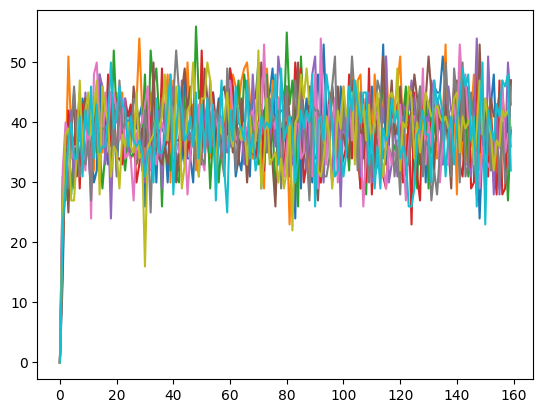

In [16]:
system_runs = main_system(*SEEDS[:N], until=60 * 160)
system_arr = np.array([run.th_stats for run in system_runs])
plt.plot(system_arr.T)
plt.show()

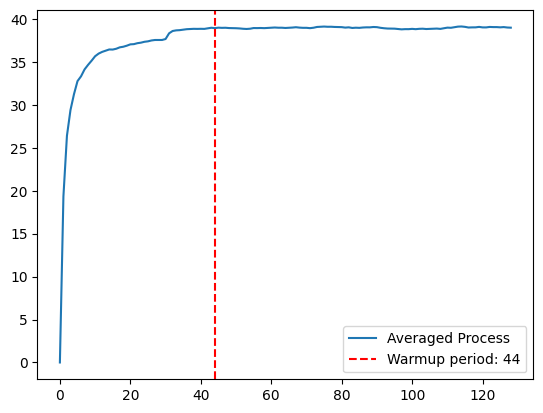

In [17]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [18]:
hourly_throughput_warmup_period = welch.warmup_period

In [19]:
def t_student_critical_value(alpha: float, n: int):
    return stats.t.ppf(1 - alpha, n - 1)

In [20]:
def analyze_hourly_throughput(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [statistics.mean(run.th_stats[warmup_period:]) for run in runs]
    throughput_sample_mean = statistics.mean(sample)
    throughput_sample_variance = statistics.variance(
        sample, xbar=throughput_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(throughput_sample_variance / n)
    return throughput_sample_mean, throughput_sample_variance, half_interval

In [21]:
system_runs = main_system(*SEEDS[N:M], until=60 * 160)
alpha = 0.05
throughput_sample_mean, throughput_sample_variance, half_interval = (
    analyze_hourly_throughput(
        system_runs, warmup_period=hourly_throughput_warmup_period, alpha=alpha
    )
)
print(f"Throughput Sample Mean: {throughput_sample_mean:.2f}")
print(f"Throughput Sample Variance: {throughput_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({throughput_sample_mean - half_interval:.2f}, {throughput_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / throughput_sample_mean:.2f}%")

Throughput Sample Mean: 39.00
Throughput Sample Variance: 0.27
Half Interval: 0.09
Confidence Interval [alpha=0.05]: (38.91, 39.08)
Relative Error: 0.22%


In [62]:
AVG_HOURLY_THROUGHPUT = throughput_sample_mean

## Time in System Stats Evaluation

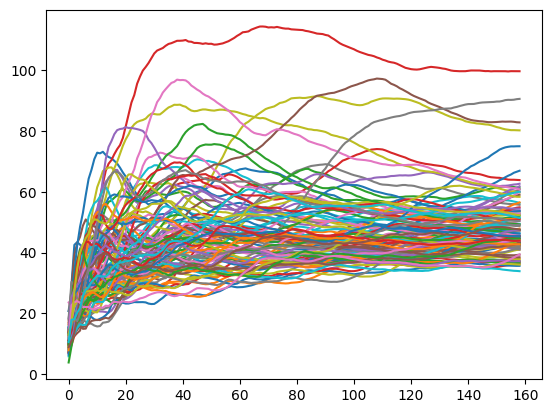

In [22]:
system_runs = main_system(*SEEDS[M:O], until=60 * 160)
tis_series_list = [run.tis_stats for run in system_runs]
min_len = min(len(s) for s in tis_series_list)
truncated_tis_series = [s[:min_len] for s in tis_series_list]
system_arr = np.array(truncated_tis_series)
plt.plot(system_arr.T)
plt.show()

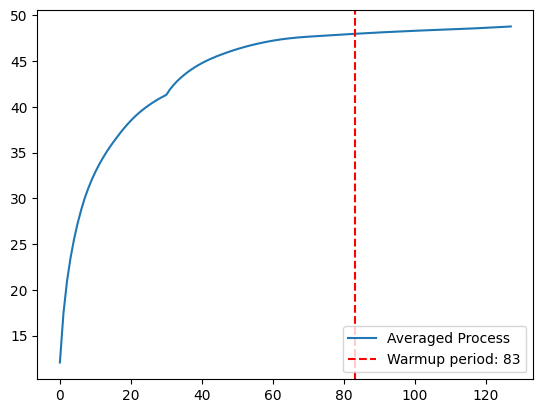

In [23]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [24]:
tis_warmup_period = welch.warmup_period

In [25]:
def analyze_time_in_system(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.time_in_system
            for job in run.jobs
            if job.done and job.completion_time > tis_warmup_period
        ])
        for run in runs
    ]
    tis_sample_mean = statistics.mean(sample)
    tis_sample_variance = statistics.variance(
        sample, xbar=tis_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(tis_sample_variance / n)
    return tis_sample_mean, tis_sample_variance, half_interval

In [26]:
system_runs = main_system(*SEEDS[O:P], until=60 * 160)
alpha = 0.05
tis_sample_mean, tis_sample_variance, half_interval = (
    analyze_time_in_system(
        system_runs, warmup_period=tis_warmup_period, alpha=alpha
    )
)
print(f"Time in System Sample Mean: {tis_sample_mean:.2f}")
print(f"Time in System Sample Variance: {tis_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({tis_sample_mean - half_interval:.2f}, {tis_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / tis_sample_mean:.2f}%")

Time in System Sample Mean: 51.52
Time in System Sample Variance: 199.48
Half Interval: 2.35
Confidence Interval [alpha=0.05]: (49.17, 53.86)
Relative Error: 4.55%


In [56]:
AVG_TIME_IN_SYSTEM = tis_sample_mean

## Tardiness Stats Evaluation

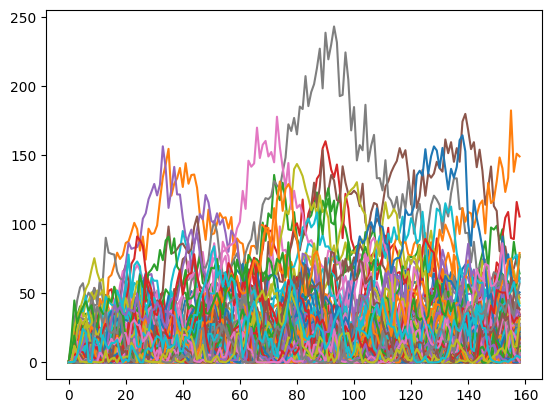

In [30]:
system_runs = main_system(*SEEDS[P:Q], until=60 * 160)
system_arr = np.array([run.tardiness_stats for run in system_runs])
plt.plot(system_arr.T)
plt.show()

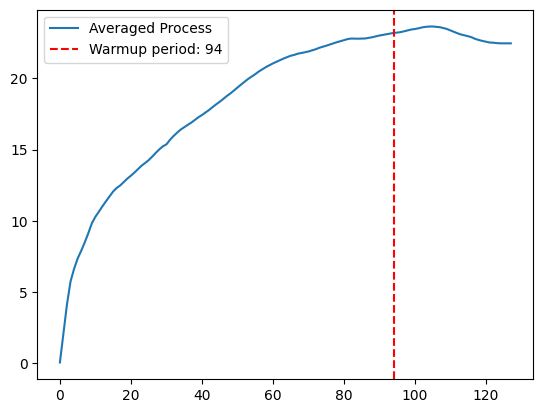

In [31]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [32]:
tardiness_warmup_period = welch.warmup_period

In [33]:
def analyze_tardiness(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.tardiness
            for job in run.jobs
            if job.done and job.completion_time > tardiness_warmup_period
        ])
        for run in runs
    ]
    tardiness_sample_mean = statistics.mean(sample)
    tardiness_sample_variance = statistics.variance(
        sample, xbar=tardiness_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(tardiness_sample_variance / n)
    return tardiness_sample_mean, tardiness_sample_variance, half_interval

In [34]:
system_runs = main_system(*SEEDS[Q:R], until=60 * 160)
alpha = 0.05
tardiness_sample_mean, tardiness_sample_variance, half_interval = (
    analyze_time_in_system(
        system_runs, warmup_period=tardiness_warmup_period, alpha=alpha
    )
)
print(f"Tardiness Sample Mean: {tardiness_sample_mean:.2f}")
print(f"Tardiness Sample Variance: {tardiness_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({tardiness_sample_mean - half_interval:.2f}, {tardiness_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / tardiness_sample_mean:.2f}%")

Tardiness Sample Mean: 48.82
Tardiness Sample Variance: 106.20
Half Interval: 1.71
Confidence Interval [alpha=0.05]: (47.11, 50.53)
Relative Error: 3.50%


## Earliness Stats Evaluation

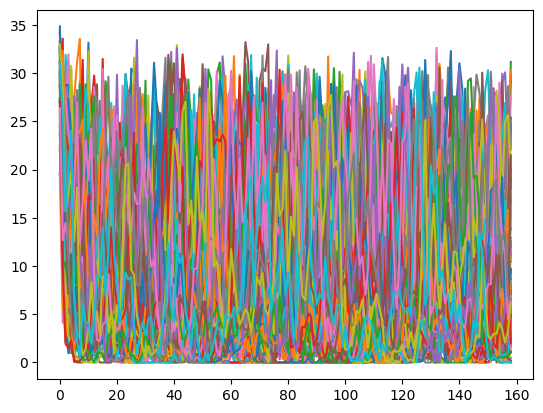

In [35]:
system_runs = main_system(*SEEDS[R:S], until=60 * 160)
system_arr = np.array([run.earliness_stats for run in system_runs])
plt.plot(system_arr.T)
plt.show()

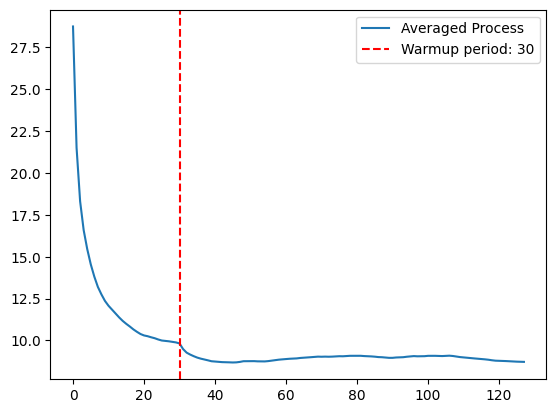

In [36]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [37]:
earliness_warmup_period = welch.warmup_period

In [38]:
def analyze_earliness(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [
        statistics.mean([
            job.earliness
            for job in run.jobs
            if job.done and job.completion_time > earliness_warmup_period
        ])
        for run in runs
    ]
    earliness_sample_mean = statistics.mean(sample)
    earliness_sample_variance = statistics.variance(
        sample, xbar=earliness_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(earliness_sample_variance / n)
    return earliness_sample_mean, earliness_sample_variance, half_interval

In [39]:
system_runs = main_system(*SEEDS[S:T], until=60 * 160)
alpha = 0.05
earliness_sample_mean, earliness_sample_variance, half_interval = (
    analyze_time_in_system(
        system_runs, warmup_period=earliness_warmup_period, alpha=alpha
    )
)
print(f"Earliness Sample Mean: {earliness_sample_mean:.2f}")
print(f"Earliness Sample Variance: {earliness_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({earliness_sample_mean - half_interval:.2f}, {earliness_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / earliness_sample_mean:.2f}%")

Earliness Sample Mean: 50.53
Earliness Sample Variance: 124.88
Half Interval: 1.86
Confidence Interval [alpha=0.05]: (48.68, 52.39)
Relative Error: 3.67%


## Number of Jobs in System Stats Evaluation

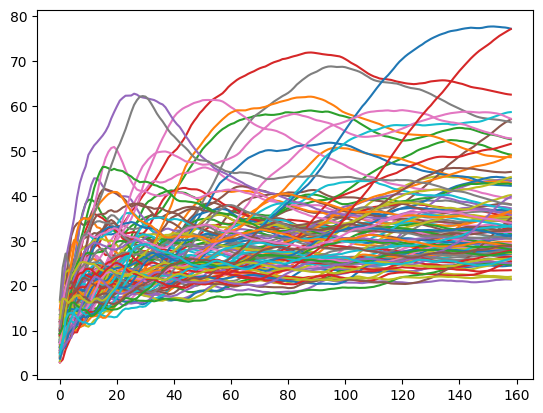

In [55]:
system_runs = main_system(*SEEDS[T:U], until=60 * 160)
system_arr = np.array([run.wip_stats for run in system_runs])
plt.plot(system_arr.T)
plt.show()

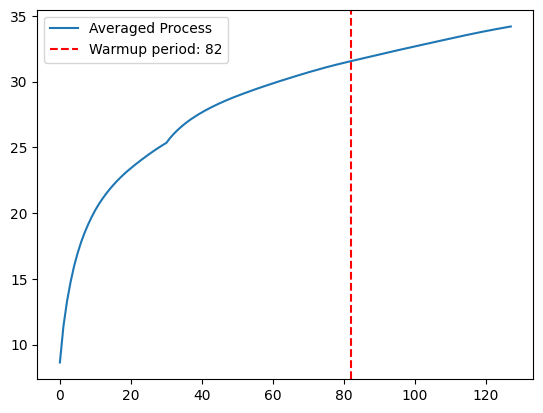

In [45]:
welch = Welch(system_arr, window_size=30, tol=0.1)
welch.plot()

In [46]:
WIP_warmup_period = welch.warmup_period

In [52]:
def analyze_WIP(
    runs: Sequence[System], warmup_period: int, alpha: float = 0.05
) -> tuple[float, float, float]:
    n = len(runs)
    sample = [(run.total_wip_area_after_warmup / (60*160 - 60*warmup_period)) for run in runs]
    wip_sample_mean = statistics.mean(sample)
    wip_sample_variance = statistics.variance(
        sample, xbar=wip_sample_mean
    )
    t = t_student_critical_value(alpha=alpha, n=n)
    half_interval = t * np.sqrt(wip_sample_variance / n)
    return wip_sample_mean, wip_sample_variance, half_interval

In [53]:
system_runs = main_system(*SEEDS[U:V], until=60 * 160, wip_warmup=WIP_warmup_period)
alpha = 0.05
wip_sample_mean, wip_sample_variance, half_interval = (
    analyze_WIP(
        system_runs, warmup_period=WIP_warmup_period, alpha=alpha
    )
)
print(f"Wip Sample Mean: {wip_sample_mean:.2f}")
print(f"Wip Sample Variance: {wip_sample_variance:.2f}")
print(f"Half Interval: {half_interval:.2f}")
print(
    f"Confidence Interval [{alpha=}]: ({wip_sample_mean - half_interval:.2f}, {wip_sample_mean + half_interval:.2f})"
)
print(f"Relative Error: {100 * half_interval / wip_sample_mean:.2f}%")

Wip Sample Mean: 33.24
Wip Sample Variance: 80.71
Half Interval: 1.49
Confidence Interval [alpha=0.05]: (31.75, 34.74)
Relative Error: 4.49%


In [57]:
AVG_JOBS_IN_SYSTEM = wip_sample_mean

## VALIDATION

## Little's Law Validation

$L = \lambda \cdot w$

avg_num_job_in_system = arrival_rate * avg_time_in_system

In [58]:
print(f"AVG_JOBS_IN_SYSTEM = {AVG_JOBS_IN_SYSTEM}")
print(f"AVG_TIME_IN_SYSTEM = {AVG_TIME_IN_SYSTEM}")
print(f"ARRIVAL_RATE = 0.65")

AVG_JOBS_IN_SYSTEM = 33.244142371022974
AVG_TIME_IN_SYSTEM = 51.51571349553293
ARRIVAL_RATE = 0.65


In [59]:
ARRIVAL_RATE * AVG_TIME_IN_SYSTEM # for the Little's Law this would result in the AVG_JOBS_IN_SYSTEM

33.48521377209641

In [65]:
print(f"Error w.r.t. expected AVG_JOBS_IN_SYSTEM: {100 * abs(ARRIVAL_RATE * AVG_TIME_IN_SYSTEM - AVG_JOBS_IN_SYSTEM)/AVG_JOBS_IN_SYSTEM} %")

Error w.r.t. expected AVG_JOBS_IN_SYSTEM: 0.7251545201044562 %


In [61]:
AVG_JOBS_IN_SYSTEM / ARRIVAL_RATE # for the Little's Law this would result in the AVG_TIME_IN_SYSTEM

51.14483441695842

In [66]:
print(f"Error w.r.t. expected AVG_TIME_IN_SYSTEM: {100 * abs(AVG_JOBS_IN_SYSTEM / ARRIVAL_RATE - AVG_TIME_IN_SYSTEM)/AVG_TIME_IN_SYSTEM} %")

Error w.r.t. expected AVG_TIME_IN_SYSTEM: 0.7199338869812427 %


## Hourly Throughput Analysis

Expected hourly throughput given arrival rate:

In [68]:
print(f"Expected hourly throughput {ARRIVAL_RATE * 60}) # 60 minutes in an hour

39.0

In [74]:
print(f"Computed hourly throughput = {AVG_HOURLY_THROUGHPUT}")

Computed hourly throughput = 38.99818965517241


In [75]:
print(f"Error w.r.t. expected hourly throughput: {100 * abs(ARRIVAL_RATE * 60 - AVG_HOURLY_THROUGHPUT)/AVG_HOURLY_THROUGHPUT} %")

Error w.r.t. expected hourly throughput: 0.004642125297601734 %
